# Determining the cost of cars

The service for selling used cars “Not a Bit, Not a Paint” is developing an application to attract new customers. Here you can quickly find out the market value of your car. Historical data is at your disposal: technical characteristics, configurations and prices of cars. You need to build a model to determine the cost.

The following are important to the customer:

- quality of prediction;
- prediction speed;
- learning time.

P.s initially the project was executed in Russian, and only then it was translated into English using an auto-translator, so errors or untranslated sections are possible.

## Data preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set_palette(sns.blend_palette(['blue', 'red'],2))

from scipy.stats import f_oneway, chi2_contingency

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from category_encoders.binary import BinaryEncoder
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

from math import sqrt

import warnings
warnings.filterwarnings('ignore')

### First look

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


DateCrawled — date the profile was downloaded from the database

VehicleType - car body type

RegistrationYear—year of vehicle registration

Gearbox - gearbox type

Power - power (hp)

Model - car model

Kilometer - mileage (km)

RegistrationMonth — month of vehicle registration

FuelType - fuel type

Brand - car brand

Repaired - whether the car was repaired or not

DateCreated — date of creation of the questionnaire

NumberOfPictures — number of photos of the car

PostalCode — postal code of the profile owner (user)

LastSeen - date of last user activity

Price - price (euros)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

VehicleType    10.58
Gearbox         5.60
Model           5.56
FuelType        9.28
Repaired       20.08
dtype: float64

In [7]:
data.duplicated().sum()

4

After a quick look at the data, we have the following:

1. There are obvious duplicates, we delete them (4 in total)

2. There are gaps (up to 20%), we will process them.

3. There are unnecessary columns (the date the ad was uploaded, the month the car was registered, the postal code of the owner of the profile, the number of photos of the car, the date of the last user activity, the date the profile was created).

### Remove duplicates

In [8]:
data = data.drop_duplicates().reset_index(drop = True)

In [9]:
data.duplicated().sum()

0

### Process the gaps

In [10]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

VehicleType    10.58
Gearbox         5.60
Model           5.56
FuelType        9.28
Repaired       20.08
dtype: float64

1. Let's start with Model. Since this attribute is the most difficult to restore, we will indicate Model = 'other' for gaps, because most likely they appeared due to the fact that the form did not have the required model when creating the questionnaire.

2. VehicleType. Let's fill in the gaps with the values ​​of the same models, if any. If not, then 'other'

3. FuelType. Similarly (we take the same model), but we will also compare it in terms of power (the same model can have both gasoline and diesel, but their power is definitely different)

4. Gearbox. Let's fill in the gaps with the values ​​of the same models, if any. If not, then 'other'.

5. Repaired. Let's look at the correlation with mileage

#### Model

In [11]:
data['Model'] = data['Model'].fillna('other')

In [12]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

VehicleType    10.58
Gearbox         5.60
FuelType        9.28
Repaired       20.08
dtype: float64

#### VehicleType

In [13]:
data["VehicleType"] = data.groupby(["Brand", "Model"])["VehicleType"].transform(lambda x: x.fillna(x.mode().iat[0]) if len(x.mode()) > 0 else x)
data["VehicleType"].fillna("other", inplace=True)
data["VehicleType"].isna().sum()

0

In [14]:
data["VehicleType"].value_counts()

sedan          106568
small           92106
wagon           69204
bus             32916
convertible     20458
coupe           17160
suv             12662
other            3291
Name: VehicleType, dtype: int64

In [15]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

Gearbox      5.60
FuelType     9.28
Repaired    20.08
dtype: float64

#### FuelType

In [16]:
data["FuelType"] = data.groupby(["Brand", "Model", "Power"])["FuelType"].transform(lambda x: x.fillna(x.mode().iat[0]) if len(x.mode()) > 0 else x)
data["FuelType"].fillna("other", inplace=True)
data["FuelType"].isna().sum()

0

In [17]:
data["FuelType"].value_counts()

petrol      243129
gasoline    104068
lpg           5342
other          907
cng            579
hybrid         243
electric        97
Name: FuelType, dtype: int64

In [18]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

Gearbox      5.60
Repaired    20.08
dtype: float64

#### Gearbox

In [19]:
data["Gearbox"] = data.groupby(["Brand", "Model"])["Gearbox"].transform(lambda x: x.fillna(x.mode().iat[0]) if len(x.mode()) > 0 else x)
data["Gearbox"].fillna("other", inplace=True)
data["Gearbox"].isna().sum()

0

In [20]:
data["Gearbox"].value_counts()

manual    285804
auto       68561
Name: Gearbox, dtype: int64

In [21]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

Repaired    20.08
dtype: float64

#### Repaired

In [22]:
rapaired = data.loc[data['Repaired'].isna() == False]

In [23]:
rapaired['Repaired'].unique()

array(['yes', 'no'], dtype=object)

In [24]:
rapaired["Repaired"] = rapaired["Repaired"].replace({"yes": 1, "no": 0})

In [25]:
crosstab = pd.crosstab(rapaired["Repaired"], rapaired["Kilometer"])
chi2, p_value, _, _ = chi2_contingency(crosstab)
n = min(crosstab.shape)
cramer_v = (chi2 / (rapaired.shape[0] * (n - 1))) ** 0.5
print("Cramer's V:", cramer_v)

Cramer's V: 0.11633596845837464


Unlucky. Cramer's correlation coefficient is close to 0, which suggests that with increasing mileage there are not necessarily more cars being repaired.

Then we will replace the gaps with the fashion of the price group of a particular car, if there is something to compare with, otherwise 'other'

In [26]:
def pricegroup(brand, model, price):
    return (price - min_p[brand, model])//step[brand, model]

In [27]:
def repaired(brand, model, price_group):
        return mode_repaired[brand, model, price_group] if mode_repaired[brand, model, price_group] in ['yes', 'no'] else 'other'

In [28]:
%%time
max_p = data.groupby(['Brand', 'Model']).Price.max()
min_p = data.groupby(['Brand', 'Model']).Price.min()

step = (max_p - min_p)/4

data['price_group'] = data.apply(lambda row: pricegroup(row['Brand'], row['Model'], row['Price']), axis=1)

grouped_data = data.groupby(['Brand', 'Model', 'price_group'])
mode_repaired = grouped_data['Repaired'].apply(lambda x: (x.mode().iat[0]) if len(x.mode()) > 0 else np.nan)

data.loc[data['Repaired'].isna(), 'Repaired'] = data.loc[data['Repaired'].isna()].apply(lambda row: repaired(row['Brand'], row['Model'], row['price_group']), axis=1)

data['Repaired'] = data['Repaired'].fillna('other')

data = data.drop('price_group', axis =1)

CPU times: user 19.5 s, sys: 132 ms, total: 19.6 s
Wall time: 19.6 s


In [29]:
data["Repaired"].value_counts()

no       318188
yes       36132
other        45
Name: Repaired, dtype: int64

In [30]:
(data.isna().sum()*100/data.shape[0]).round(2).loc[(data.isna().sum()*100/data.shape[0]).round(2) > 0]

Series([], dtype: float64)

No more passes

### Extra columns

In [31]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

In [32]:
data = data.drop(['DateCrawled', 'RegistrationMonth', 'NumberOfPictures', 'LastSeen', 'PostalCode', 'DateCreated'], axis=1)

In [33]:
data.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no


### Preprocessing

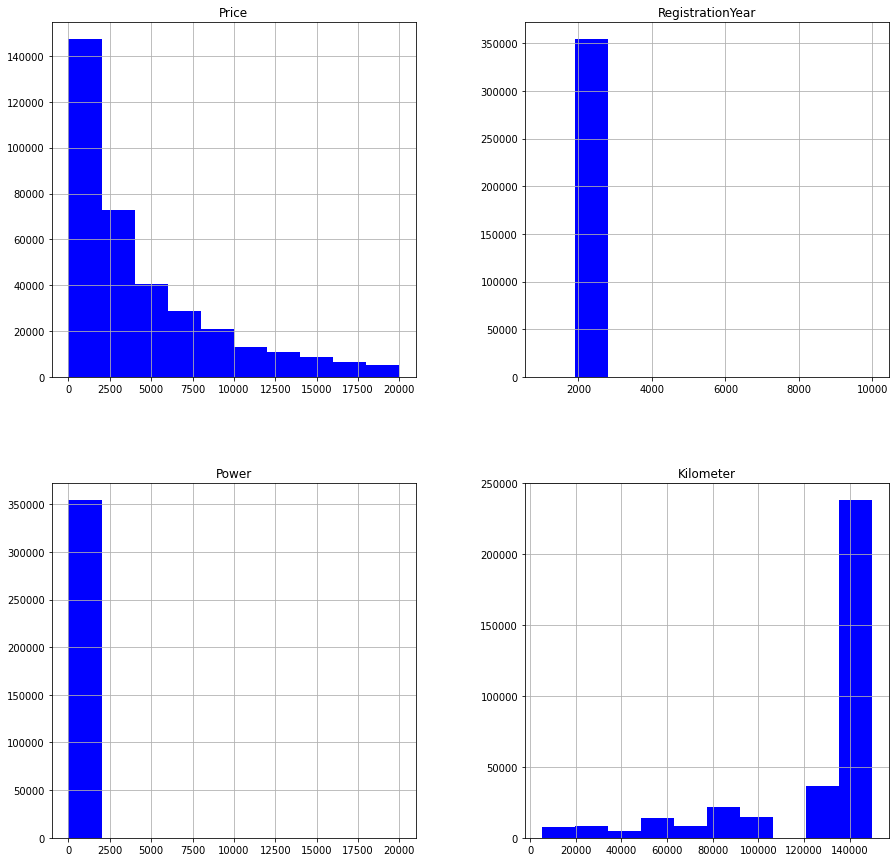

In [34]:
data.hist(figsize=(15,15));

We can see a very large number of outliers in all columns. Let's see how much of all data they occupy.

We will understand the following as outliers:

1. For the Price column - all values ​​are outside [Q25% - 1.5IQR, Q75% + 1.5IQR]

2. For the RegistrationYear column - all values ​​are outside [Q25% - 1.5IQR, 2019]

3. For Power - all values ​​are outside (0, 1500]

4. For Kilometer - all values ​​are outside [0, Q75% + 1.5IQR]

In [35]:
des = data.describe()

#price
Q25 = data.Price.quantile(0.25)
Q75 = data.Price.quantile(0.75)
IQR = Q75 - Q25
lower_price = Q25 - 1.5*IQR
upper_price = Q75 + 1.5*IQR
price = data.query('Price >= @upper_price or Price <= @lower_price').index.tolist()

#RegistrationYear
lower_year = data.RegistrationYear.quantile(0.25) - 1.5*(data.RegistrationYear.quantile(0.75) - data.RegistrationYear.quantile(0.25))
year = data.query('RegistrationYear >= 2020 or RegistrationYear <= @lower_year').index.tolist()

#Power
lower_power = 0 #data.Power.quantile(0.25) - 2*(data.Power.quantile(0.75) - data.Power.quantile(0.25))
power =  data.query('Power >= 1000 or Power <= @lower_power').index.tolist()
                                                                            
#Kilometer
upper_km = data.Kilometer.quantile(0.75) + 1.5*(data.Kilometer.quantile(0.75) - data.Kilometer.quantile(0.25))
km = data.query('Kilometer < 0 or Kilometer >= @upper_km').index.tolist()       
                                                                                
indexes = pd.Series(price + year + power + km).unique()
print(f'Выбросы составляют {round(len(indexes)*100/data.shape[0], ndigits=3)}% от общего объема'  )                                                                        

Выбросы составляют 17.712% от общего объема


17.712% is too much. Let's try to figure out the anomalies in Power, there are the most of them (Power = 0 is about 10% of the data)

In [36]:
def power_f(brand, model, fuel):
        return mode_power[brand, model, fuel] if mode_power[brand, model, fuel]>0 else 0

grouped_data_fuel = data.groupby(['Brand', 'Model', 'FuelType'])
mode_power = grouped_data_fuel['Power'].apply(lambda x: (x.mode().iat[0]) if len(x.mode()) > 0 else np.nan)

data.loc[data['Power']==0, 'Power'] = data.loc[data['Power']==0].apply(lambda row: power_f(row['Brand'], row['Model'], row['FuelType']), axis=1)

In [37]:
power =  data.query('Power >= 1000 or Power <= @lower_power').index.tolist()
indexes = pd.Series(price + year + power + km).unique()
print(f'Выбросы составляют {round(len(indexes)*100/data.shape[0], ndigits=3)}% от общего объема'  ) 

Выбросы составляют 9.408% от общего объема


Great, this volume can be discarded

In [38]:
data = data.drop(indexes).reset_index(drop=True)

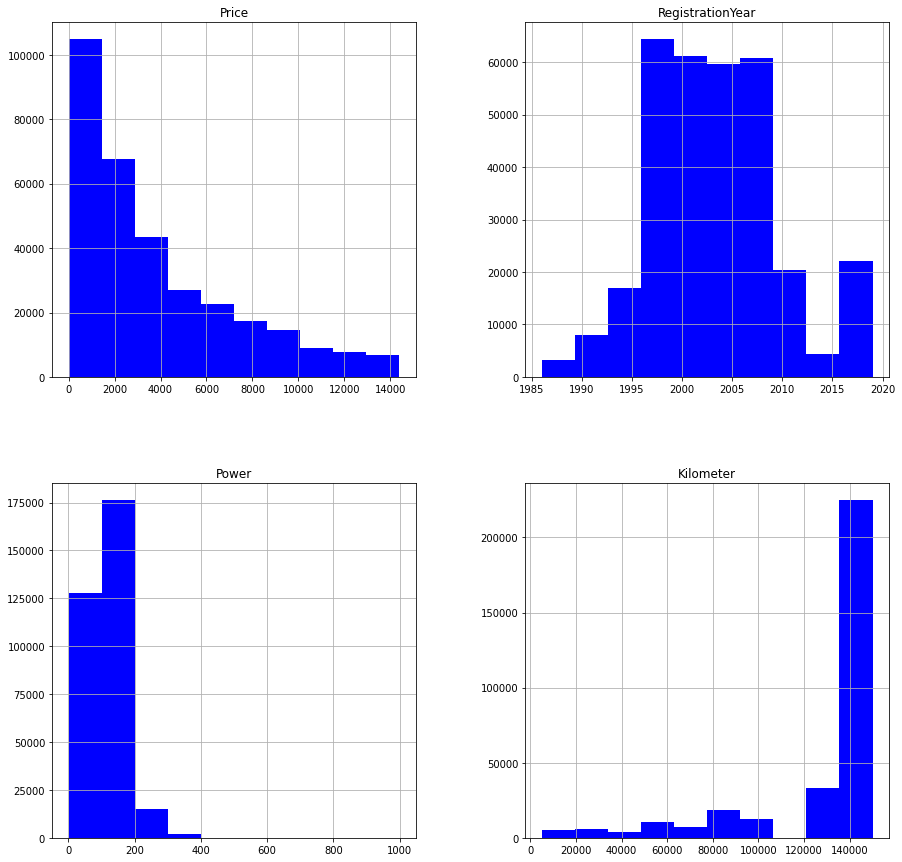

In [39]:
data.hist(figsize=(15,15));

### Data type

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321027 entries, 0 to 321026
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             321027 non-null  int64 
 1   VehicleType       321027 non-null  object
 2   RegistrationYear  321027 non-null  int64 
 3   Gearbox           321027 non-null  object
 4   Power             321027 non-null  int64 
 5   Model             321027 non-null  object
 6   Kilometer         321027 non-null  int64 
 7   FuelType          321027 non-null  object
 8   Brand             321027 non-null  object
 9   Repaired          321027 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.5+ MB


Gearbox will be replaced by 0 and 1

In [41]:
data["Gearbox"].unique()

array(['manual', 'auto'], dtype=object)

In [42]:
data["Gearbox"] = data["Gearbox"].replace({"auto": 1, "manual": 0})

### Preprocessing conclusion

Work done:

1. Removed obvious duplicates

2. Filled in all the gaps with group fashion

3. We discarded the columns with information about the questionnaire itself; we don’t need them

4. Processed anomalies, got rid of 0 in Power, discarded about 9% of the data

5. Converted Gearbox to a numeric type

Now we are ready to move on to model training

## Model training

Let's take a few more important steps:

1. Let's split the data into train and test

2. Let's do OHE

3. Let's do BinaryEncoding

3. Let's scale the data

### Preparation

#### Breakdown into train and test

In [43]:
features = data.drop('Price', axis=1)
target = data.Price

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=12345)
print(len(features_train), len(features_test))

240770 80257


In [44]:
features_train.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
79940,small,2001,0,75,polo,150000,gasoline,volkswagen,no
39634,wagon,2000,0,155,156,150000,petrol,alfa_romeo,no
310839,convertible,1998,0,116,z_reihe,150000,petrol,bmw,no
252141,sedan,1990,0,69,golf,150000,petrol,volkswagen,no
27656,sedan,2018,0,122,golf,90000,petrol,volkswagen,no


In [45]:
features_test.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
67208,other,1987,0,48,other,40000,petrol,sonstige_autos,no
16487,small,2014,0,95,fiesta,50000,gasoline,ford,no
246979,sedan,2010,0,75,2_reihe,60000,petrol,peugeot,no
161829,sedan,2010,0,90,ceed,70000,petrol,kia,no
316194,wagon,2012,0,105,a3,30000,petrol,audi,no


In [46]:
features_train, features_test, target_train, target_test = features_train.reset_index(drop=True), features_test.reset_index(drop=True), target_train.reset_index(drop=True), target_test.reset_index(drop=True)

#### OHE

In [47]:
ohe_cols = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired']

features_train[ohe_cols] = features_train[ohe_cols].astype(str)
features_test[ohe_cols] = features_test[ohe_cols].astype(str)

ohe = OneHotEncoder(drop='first', sparse=False)

train_encoded_ohe = ohe.fit_transform(features_train[ohe_cols])

test_encoded_ohe = ohe.transform(features_test[ohe_cols])

train_encoded_ohe_df = pd.DataFrame(train_encoded_ohe, columns=ohe.get_feature_names(ohe_cols))
test_encoded_ohe_df = pd.DataFrame(test_encoded_ohe, columns=ohe.get_feature_names(ohe_cols))

features_train_encoded = pd.concat([features_train.drop(columns=ohe_cols), train_encoded_ohe_df], axis=1)
features_test_encoded = pd.concat([features_test.drop(columns=ohe_cols), test_encoded_ohe_df], axis=1)

features_train = features_train_encoded
features_test = features_test_encoded

#### Binary Encoding

In [48]:
bin_cols = ['Model', 'Brand']

In [49]:
bin_encoder = BinaryEncoder()

In [50]:
bin_encoder.fit(features_train[bin_cols])

train_encoded = bin_encoder.transform(features_train[bin_cols])
features_test_encoded = bin_encoder.transform(features_test[bin_cols])

In [51]:
features_train = pd.concat([features_train.drop(columns=bin_cols), train_encoded], axis=1)
features_test = pd.concat([features_test.drop(columns=bin_cols), features_test_encoded], axis=1)
print(len(features_train), len(features_test))

240770 80257


#### Data scaling

In [52]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [53]:
features_train.head(3)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_4,Model_5,Model_6,Model_7,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
0,-0.363123,-0.794558,0.538212,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,0,0,0,1
1,-0.523089,0.781544,0.538212,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,1,0
2,-0.843021,0.013194,0.538212,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,1,0,0,0,0,1,1


In [54]:
features_test.head(3)

,RegistrationYear,Power,Kilometer,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_wagon,...,Model_4,Model_5,Model_6,Model_7,Brand_0,Brand_1,Brand_2,Brand_3,Brand_4,Brand_5
0,-2.602646,-1.326493,-2.594222,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1,1,0,0,1,0,0,0,0,1
1,1.716435,-0.400533,-2.309455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,1,1,0,0,1,0,0,0
2,1.076571,-0.794558,-2.024689,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0,1,0,1,0,1,0,0,0,0


In [55]:
features_train[numeric].describe()

,RegistrationYear,Power,Kilometer
count,2.407700e+05,2.407700e+05,2.407700e+05
mean,-2.586839e-15,1.531044e-16,6.343446e-17
std,1.000002e+00,1.000002e+00,1.000002e+00
min,-2.762612e+00,-2.252453e+00,-3.590906e+00
25%,-6.830548e-01,-7.945585e-01,-1.737045e-01
50%,-4.319088e-02,-2.035202e-01,5.382124e-01
75%,5.966730e-01,5.057257e-01,5.382124e-01
max,2.516265e+00,1.740942e+01,5.382124e-01


In [56]:
features_test[numeric].describe()

,RegistrationYear,Power,Kilometer
count,80257.000000,80257.000000,80257.000000
mean,-0.006837,0.000328,0.002555
std,0.997931,1.003640,0.993753
min,-2.762612,-2.252453,-3.590906
25%,-0.683055,-0.794558,-0.173705
50%,-0.043191,-0.203520,0.538212
75%,0.596673,0.505726,0.538212
max,2.516265,17.409419,0.538212


### Learning

We will try 5 models:

1. LightGBM
2. CatBoost
3. LinearRegression
4. RandomForestRegressor
5. KNN-regressor

In [57]:
# Looking for the best model with following grid:
# param_grid = {
#     'lightgbm': {
#         'n_estimators': [100, 200, 300],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'max_depth': [3, 5, 7]
#     },
#     'catboost': {
#         'iterations': [100, 200, 300],
#         'learning_rate': [0.01, 0.1, 0.2],
#         'depth': [3, 5, 7]
#     },
#     'linear_regression': {},
#     'random_forest': {
#         'n_estimators': [50, 100, 200],
#         'max_depth': [3, 5, 7]
#     },
#     'knn_regressor': {
#         'n_neighbors': [3, 5, 7],
#         'weights': ['uniform', 'distance']
#     }
# }

param_grid = {
    'lightgbm': {
        'learning_rate': [0.2], 
        'max_depth': [7], 
        'n_estimators': [300]
    },
    'catboost': {
        'depth': [7], 'iterations': [300], 'learning_rate': [0.2]
    },
    'linear_regression': {},
    'random_forest': {
        'max_depth': [7], 'n_estimators': [100]
    },
    'knn_regressor': {
        'n_neighbors': [7], 'weights': ['distance']
    }
}

In [58]:
models = {
    'lightgbm': LGBMRegressor(),
    'catboost': CatBoostRegressor(verbose=False),
    'linear_regression': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'knn_regressor': KNeighborsRegressor()
}

In [59]:
%%time
grid_search_results = {}
for model_name, model in models.items():
    if model_name in param_grid:
        print(f"Running GridSearchCV for {model_name}...")
        grid_search = GridSearchCV(model, param_grid[model_name], cv=5, scoring='neg_root_mean_squared_error')
        grid_search.fit(features_train, target_train)
        grid_search_results[model_name] = grid_search

Running GridSearchCV for lightgbm...
Running GridSearchCV for catboost...
Running GridSearchCV for linear_regression...
Running GridSearchCV for random_forest...
Running GridSearchCV for knn_regressor...
CPU times: user 51min 35s, sys: 11min 28s, total: 1h 3min 3s
Wall time: 1h 3min 26s


In [60]:
for model_name, grid_search in grid_search_results.items():
    print(f"Results for {model_name}:")
    print("Best Score (RMSE):", (-1)*grid_search.best_score_)  # Отрицательное значение MSE
    print("Best Parameters:", grid_search.best_params_)
    print("")

Results for lightgbm:
Best Score (RMSE): 1466.1904860815866
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300}

Results for catboost:
Best Score (RMSE): 1475.336620966759
Best Parameters: {'depth': 7, 'iterations': 300, 'learning_rate': 0.2}

Results for linear_regression:
Best Score (RMSE): 2397.259252194891
Best Parameters: {}

Results for random_forest:
Best Score (RMSE): 1838.7417591420103
Best Parameters: {'max_depth': 7, 'n_estimators': 100}

Results for knn_regressor:
Best Score (RMSE): 1554.1321392336597
Best Parameters: {'n_neighbors': 7, 'weights': 'distance'}



In [61]:
best_model = grid_search_results['lightgbm'].best_estimator_

In [62]:
%%time
model_time_fit = {}
model_time_predict = {}

for model_name, model in models.items():
    if model_name in param_grid:
        model =  grid_search_results[model_name].best_estimator_
        print(f"Running {model_name}...")
        tic = time.perf_counter()
        model.fit(features_train, target_train)
        toc = time.perf_counter()
        model_time_fit[model_name] = toc - tic
        tic = time.perf_counter()
        model.predict(features_train)
        toc = time.perf_counter()
        model_time_predict[model_name] = toc - tic

Running lightgbm...
Running catboost...
Running linear_regression...
Running random_forest...
Running knn_regressor...
CPU times: user 25min 14s, sys: 13min 5s, total: 38min 20s
Wall time: 38min 28s


Let's look at the training time

In [63]:
model_time_fit

{'lightgbm': 366.7995383478701,
 'catboost': 12.438724968582392,
 'linear_regression': 0.8910087645053864,
 'random_forest': 49.0315555408597,
 'knn_regressor': 0.03547801077365875}

For some reason, LightGBM takes a very long time to learn on this dataframe, although comparative tests show that it should be faster than catboost

To compare the performance of models over their time, let's look at how much the model error differs from the threshold value during the time they were trained

In [64]:
fit_compare = {model_name:( 2500-(-1*grid_search_results[model_name].best_score_))/model_time_fit[model_name] for model_name in models.keys()}

In [65]:
fit_compare

{'lightgbm': 2.8184591468540936,
 'catboost': 82.37688200529601,
 'linear_regression': 115.30834700839578,
 'random_forest': 13.486381036941408,
 'knn_regressor': 26660.679111936453}

The KNN regressor showed itself to be much better than the others, but it’s too early to draw conclusions, let’s see how long the models take to make predictions

In [66]:
model_time_predict

{'lightgbm': 4.163687713444233,
 'catboost': 0.09454864636063576,
 'linear_regression': 0.04047355428338051,
 'random_forest': 1.3559154197573662,
 'knn_regressor': 1873.688832141459}

In [67]:
predict_compare= {model_name:( 2500-(-1*grid_search_results[model_name].best_score_))/model_time_predict[model_name] for model_name in models.keys()}

In [68]:
predict_compare

{'lightgbm': 248.29179925773985,
 'catboost': 10837.419872991939,
 'linear_regression': 2538.4661570801827,
 'random_forest': 487.68398915053143,
 'knn_regressor': 0.5048158715261689}

Here KNN turned out to be the worst option.

### Results of training

Total we have:

1. LightGBM
        RMSE = 1466.19
        Training time = 366 seconds
        Prediction time = 4.16 seconds
        Training score = 2.81
        Prediction Score = 248.29
        
2. CatBoost
        RMSE = 1475.33
        Training time = 12 seconds
        Prediction time = 0.09 seconds
        Tuition Score = 82.37
        Prediction Score = 10837.41

3. Linear Regression:
        RMSE = 2397.26
        Training time = 0.89 seconds
        Prediction time = 0.04 seconds
        Tuition Score = 115.30
        Prediction Score = 2538.46

4. Random Forest:
        RMSE = 1838.74
        Training time = 49 seconds
        Prediction time = 1.35 seconds
        Training account = 13.48
        Prediction Score = 487.68

5. KNN Regressor:
        RMSE = 1554.13
        Training time = 0.03 seconds
        Prediction time = 1873.68 seconds
        Tuition account = 26660.67
        Prediction Score = 0.50
        
        
The best result was shown by LightGBM, however, the training time of this model is not commensurate with the increase in result it gives compared to CatBoost, whose result is only 9 euros more, but at the same time we have both adequate training time and prediction time. Linear regression did not cope with the task at all, showing an RMSE value greater than the threshold. Random Forest is inferior to CatBoost in all respects, so there is no point in using it either. KNN Regressor has too long a prediction time, which is why it is also not suitable. So we choose CatBoost

## Model analysis

In [72]:
model = CatBoostRegressor(verbose=False, depth=7, iterations=300, learning_rate=0.2)
tic = time.perf_counter()
model.fit(features_train, target_train)
toc = time.perf_counter()
preds = model.predict(features_test)
toe = time.perf_counter()
print(f'RMSE = {round(mean_squared_error(target_test, preds)**0.5,ndigits=2)}, время обучения = {round(toc-tic,ndigits=2)}, время предсказания = {round(toe-toc,ndigits=2)}')

RMSE = 1466.56, время обучения = 12.92, время предсказания = 0.03


### Conclusion

Excellent, the model on the test sample shows a result much lower than the threshold, the training and prediction time is also adequate, the model can safely be used to estimate the cost of a car.